# Waterbirds Dataset
- Main page: https://wilds.stanford.edu/
- Github: https://github.com/p-lambda/wilds
- Installation: **pip install wilds**
- Subpopulation size
    - Majority: waterbirds-water (1600 images) + landbirds-land (1600 images)
    - Minority: waterbirds-land (400 images) + landbirds-water (400 images)    

In [1]:
EXP_ROOT_PATH = '../../experiments/waterbirds' # experiment root path

In [2]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.datasets.wilds_dataset import WILDSDataset, WILDSSubset

import torchvision.transforms as transforms
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from tqdm.notebook import trange, tqdm

In [3]:
dataset = get_dataset(dataset="waterbirds", download=True)
assert dataset.is_classification 
img_dict = {}
img_dict = {'00':[], '01':[], '10':[], '11':[]}
for i in range(len(dataset)):
    pil_image, y, metadata = dataset[i]
    img_dict[str(metadata.numpy()[0])+str(metadata.numpy()[1])].append(pil_image)
for k,v in img_dict.items():
    random.Random(42).shuffle(v)

You can also download the dataset manually at https://wilds.stanford.edu/downloads.


0Byte [00:00, ?Byte/s]

Extracting data/waterbirds_v1.0/archive.tar.gz to data/waterbirds_v1.0

It took 1.76 minutes to download and uncompress the dataset.



## Dataset samples

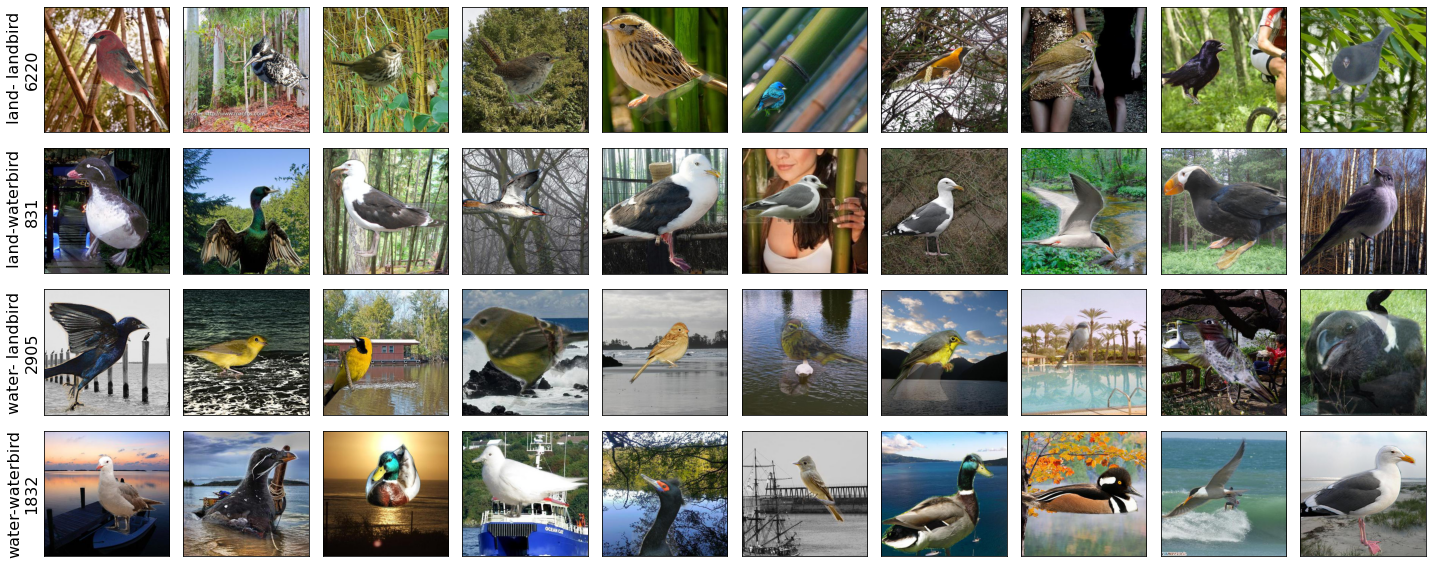

In [4]:
plt.figure(figsize=(20,len(img_dict)*2))
for i, (k,v) in enumerate(img_dict.items()):
    for j in range(10):
        img = v[j]
        w,h = img.size
        s = min(w,h)
        img = img.crop(((w-s)/2,(h-s)/2,(w+s)/2,(h+s)/2))
        plt.subplot(len(img_dict), 10, i*10+j+1)
        plt.imshow(img)
        plt.ylabel(dataset._metadata_map['background'][int(k[0])]+'-'+dataset._metadata_map['y'][int(k[1])]+'\n'+str(len(v)), fontsize=16) if j==0 else None
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.show()
plt.close()

## Prepare data

In [ ]:
TRAIN_NUM = [1600,400] # [majority, minority] for each class
VAL_NUM   = [200,200] # [majority, minority] for each class
print('majority : minority = {:.2f} : {:.2f}'.format(\
    TRAIN_NUM[0]/(TRAIN_NUM[0]+TRAIN_NUM[1]), TRAIN_NUM[1]/(TRAIN_NUM[0]+TRAIN_NUM[1])))

split_list = {'train':{'landbirds' : img_dict['00'][:TRAIN_NUM[0]] \
                             + img_dict['10'][:TRAIN_NUM[1]], \
                       'waterbirds': img_dict['01'][:TRAIN_NUM[1]] \
                             + img_dict['11'][:TRAIN_NUM[0]] }, \
              'majority-val':{'landbirds' : img_dict['00'][-VAL_NUM[0]:], \
                               'waterbirds': img_dict['11'][-VAL_NUM[0]:] }, \
              'minority-val':{'landbirds' : img_dict['10'][-VAL_NUM[1]:], \
                                   'waterbirds': img_dict['01'][-VAL_NUM[1]:] }}
for cls, img_list in split_list['train'].items():
    random.Random(42).shuffle(img_list)
    
# Data Loading 
DATA_ROOT_PATH = os.path.join(EXP_ROOT_PATH, 'data') 
if os.path.exists(DATA_ROOT_PATH) and os.path.isdir(DATA_ROOT_PATH):
    shutil.rmtree(DATA_ROOT_PATH)
os.makedirs(DATA_ROOT_PATH, exist_ok = False)

for k,v in split_list.items():
    for i_cls, (c,pil_imgs) in enumerate(v.items()):
        os.makedirs(os.path.join(DATA_ROOT_PATH, k, str(i_cls)) , exist_ok = True)
        print(DATA_ROOT_PATH, k, i_cls, c)
        for i_img, pil_img in tqdm(enumerate(pil_imgs)):
            dst_path = os.path.join(DATA_ROOT_PATH, k, str(i_cls), str(i_img)+'.jpg')
            pil_img.save(dst_path)